In [ ]:
import tensorflow as tf

In [ ]:
# import our helper function from githup
!wget https://raw.githubusercontent.com/moamen1358/helper_functions_moamen/main/mmm.py
from mmm import create_tensorboard_callback,walk_through_dir,unzip_data

--2024-05-09 15:57:15--  https://raw.githubusercontent.com/moamen1358/helper_functions_moamen/main/mmm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10911 (11K) [text/plain]
Saving to: ‘mmm.py’

mmm.py              100%[===================>]  10.66K  --.-KB/s    in 0s      

2024-05-09 15:57:15 (66.5 MB/s) - ‘mmm.py’ saved [10911/10911]



In [ ]:
# load our dataset from tensorflow hub
import tensorflow_datasets as tfds
(train_data,test_data) , ds_info = tfds.load(name='food101',
                             split=['train','validation'],
                             as_supervised=True,
                             shuffle_files=True,
                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteBN6XL1/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteBN6XL1/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
#  get the food101 classes names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

label is 75


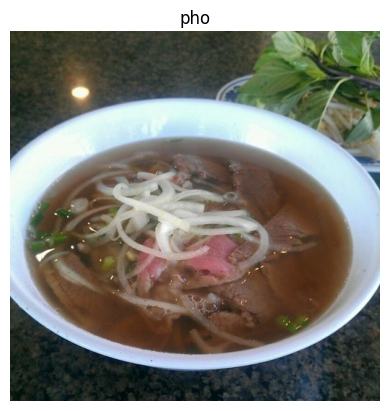

In [ ]:
# visualize one image sample
import matplotlib.pyplot as plt
for image,label in train_data.take(1):
  plt.imshow(image)
  print(f'label is {label}')
  plt.title(class_names[label.numpy()])
  plt.axis(False)

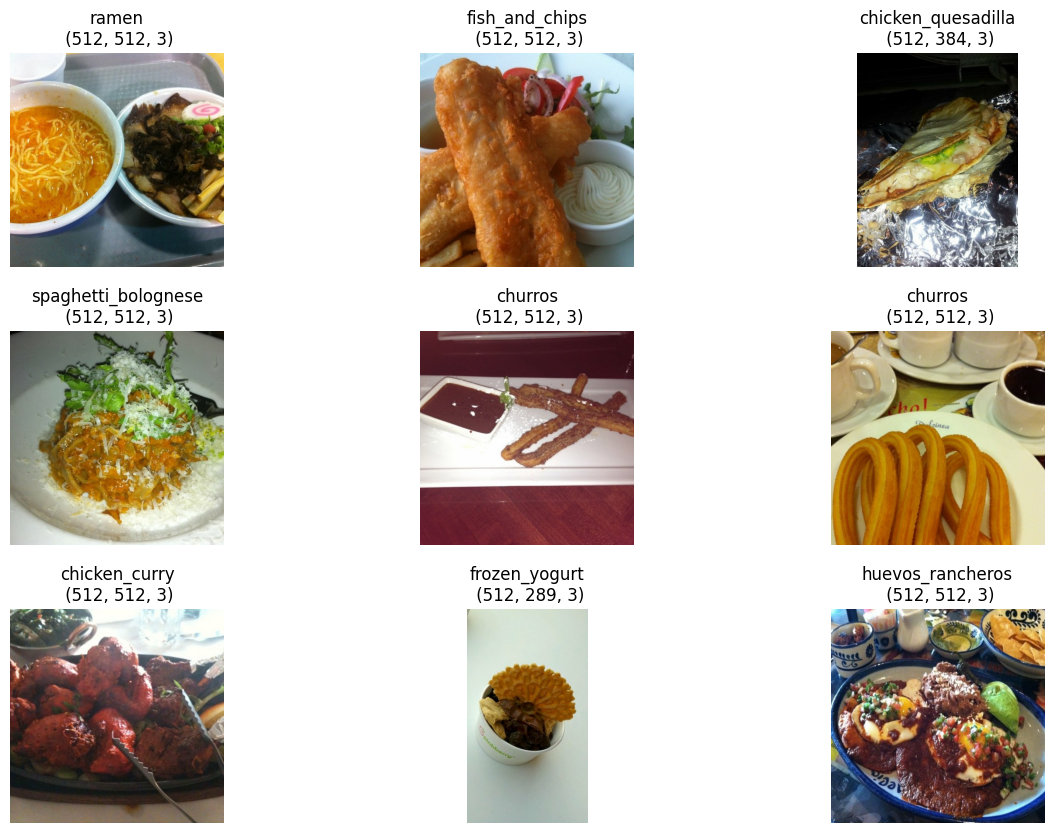

In [ ]:
# visualize some imag samples from our train_data
plt.figure(figsize=(15,10))
for i in range(9):
  for image,label in train_data.take(1):
    plt.subplot(3,3,i+1)
    plt.imshow(image/255)
    plt.title(f'{class_names[label.numpy()]}\n {image.shape}')
    plt.axis(False)
    plt.subplots_adjust(hspace=0.3)


In [ ]:
# function to preprocess the image
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# apply the preprocess_img to all data set
train_data = train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size= 32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size= 32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# create callbacks
from mmm import create_tensorboard_callback

checkpoint_path = "model_checkpoints.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

# set up mixed percision

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
import tensorflow as tf

# Create base model with pre-trained weights
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Define input layer
inputs = tf.keras.Input(shape=(224, 224, 3), name='input_layer')

# Pass inputs through the base model
x = base_model(inputs, training=False)

# Add global average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add dense layer for classification
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20240509-093316
Epoch 1/3


I0000 00:00:1715247240.030930     126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 154s 47ms/step - accuracy: 0.4302 - loss: 2.4732 - val_accuracy: 0.6576 - val_loss: 1.3134
Epoch 2/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6533 - val_loss: 1.3166
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 76s 32ms/step - accuracy: 0.6273 - loss: 1.4535 - val_accuracy: 0.6758 - val_loss: 1.1937


In [ ]:
model_evaluate = model.evaluate(test_data)
model_evaluate

790/790 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.6792 - loss: 1.1992


[1.1939269304275513, 0.6799207925796509]

In [ ]:
model.save('model_acc_67.keras')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/My Drive/model_acc_73')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/My Drive/model_acc_73')


In [ ]:
#  fine tuning our model unfreeze last 10 layers
model.trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
for layer in base_model.layers:
  print(layer,layer.trainable)

<InputLayer name=input_layer, built=True> False
<Rescaling name=rescaling, built=True> False
<Normalization name=normalization, built=True> False
<Rescaling name=rescaling_1, built=True> False
<ZeroPadding2D name=stem_conv_pad, built=True> False
<Conv2D name=stem_conv, built=True> False
<BatchNormalization name=stem_bn, built=True> False
<Activation name=stem_activation, built=True> False
<DepthwiseConv2D name=block1a_dwconv, built=True> False
<BatchNormalization name=block1a_bn, built=True> False
<Activation name=block1a_activation, built=True> False
<GlobalAveragePooling2D name=block1a_se_squeeze, built=True> False
<Reshape name=block1a_se_reshape, built=True> False
<Conv2D name=block1a_se_reduce, built=True> False
<Conv2D name=block1a_se_expand, built=True> False
<Multiply name=block1a_se_excite, built=True> False
<Conv2D name=block1a_project_conv, built=True> False
<BatchNormalization name=block1a_project_bn, built=True> False
<Conv2D name=block2a_expand_conv, built=True> False
<Ba

In [ ]:
history_fine_tuning = model.fit(train_data,
                                epochs=10,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps = int(.15*len(test_data)),
                                callbacks = [create_tensorboard_callback(dir_name='food101',
                                                                         experiment_name='fine_tuning'),
                                              model_checkpoint],
                                initial_epoch=history_101_food_classes_feature_extract.epoch[-1])

Saving TensorBoard log files to: food101/fine_tuning/20240509-093845
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 77s 32ms/step - accuracy: 0.6627 - loss: 1.2982 - val_accuracy: 0.6915 - val_loss: 1.1494
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6814 - val_loss: 1.1620
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 75s 31ms/step - accuracy: 0.6881 - loss: 1.1947 - val_accuracy: 0.6925 - val_loss: 1.1188
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7029 - val_loss: 1.1107
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 74s 31ms/step - accuracy: 0.7039 - loss: 1.1200 - val_accuracy: 0.7031 - val_loss: 1.1212
Epoch 8/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7013 - val_loss: 1.1036
Epoch 9/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 74s 31ms/step - accuracy: 0.7179 - loss: 1.0713 - val_accuracy: 0.7062 - val_lo

In [ ]:
model_fine_evaluate = model.evaluate(test_data)
model_fine_evaluate

790/790 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.6989 - loss: 1.1107


[1.1054294109344482, 0.7013465166091919]

In [ ]:
model.save('model_acc_70.keras')

In [ ]:
history_fine_tuning_2 = model.fit(train_data,
                                epochs=40,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps = int(.15*len(test_data)),
                                callbacks = [create_tensorboard_callback(dir_name='food101',
                                                                         experiment_name='fine_tuning'),
                                              model_checkpoint],
                                initial_epoch=history_fine_tuning.epoch[-1])

Saving TensorBoard log files to: food101/fine_tuning/20240509-095033
Epoch 10/40
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 76s 32ms/step - accuracy: 0.7262 - loss: 1.0397 - val_accuracy: 0.6992 - val_loss: 1.1207
Epoch 11/40
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6944 - val_loss: 1.1141
Epoch 12/40
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 79s 32ms/step - accuracy: 0.7367 - loss: 0.9922 - val_accuracy: 0.6949 - val_loss: 1.1069
Epoch 13/40
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6994 - val_loss: 1.1091
Epoch 14/40
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 78s 31ms/step - accuracy: 0.7480 - loss: 0.9481 - val_accuracy: 0.6973 - val_loss: 1.1176
Epoch 15/40
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7031 - val_loss: 1.0973
Epoch 16/40
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 77s 31ms/step - accuracy: 0.7464 - loss: 0.9337 - val_accuracy: 0.7032 -

In [ ]:
model_fine_evaluate_2 = model.evaluate(test_data)
model_fine_evaluate_2

790/790 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.6878 - loss: 1.2034


[1.1962894201278687, 0.6904950737953186]

In [ ]:
# trying DenseNet - 161	 model
import tensorflow as tf

# Create base model with pre-trained weights
base_model = tf.keras.applications.ResNet101(
    include_top=False,
    weights='imagenet',
    classifier_activation='softmax'
)
base_model.trainable = False

# Define input layer
inputs = tf.keras.Input(shape=(224, 224, 3), name='input_layer')

# Pass inputs through the base model
x = base_model(inputs, training=False)

# Add global average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add dense layer for classification
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [ ]:
history_Resnet_no = model.fit(train_data,
                                epochs=10,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps = int(.15*len(test_data)),
                                callbacks = [create_tensorboard_callback(dir_name='food101',
                                                                         experiment_name='resnet'),
                                              model_checkpoint])

Saving TensorBoard log files to: food101/resnet/20240509-111325
Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 179s 64ms/step - accuracy: 0.3357 - loss: 2.9760 - val_accuracy: 0.5273 - val_loss: 1.9360
Epoch 2/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5172 - val_loss: 1.9392
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 131s 55ms/step - accuracy: 0.5466 - loss: 1.8451 - val_accuracy: 0.5596 - val_loss: 1.7796
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5551 - val_loss: 1.8287
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 131s 55ms/step - accuracy: 0.6012 - loss: 1.5825 - val_accuracy: 0.5575 - val_loss: 1.8577
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5622 - val_loss: 1.8214
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 135s 57ms/step - accuracy: 0.6328 - loss: 1.4236 - val_accuracy: 0.5702 - val_loss: 1.7829
Epoch 8/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5787 - val_loss: 1.7727
Epoch 9/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 130s 55ms/step - a

In [ ]:
model_resnet_evaluate = model.evaluate(test_data)
model_resnet_evaluate

790/790 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.5685 - loss: 1.8453


[1.8472023010253906, 0.5668118596076965]

In [ ]:
#  fine tuning our model unfreeze last 10 layers
base_model.trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
#  fine tuning our model unfreeze last 10 laye
for layer in base_model.layers:
  print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [ ]:
history_Resnet_fine_tune = model.fit(train_data,
                                epochs=20,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps = int(.15*len(test_data)),
                                callbacks = [create_tensorboard_callback(dir_name='food101',
                                                                         experiment_name='resnet'),
                                              model_checkpoint],
                                initial_epoch = history_Resnet_no.epoch[-1])


Saving TensorBoard log files to: food101/resnet/20240509-112957
Epoch 10/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 132s 55ms/step - accuracy: 0.6780 - loss: 1.2127 - val_accuracy: 0.5728 - val_loss: 1.8807
Epoch 11/20


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5710 - val_loss: 1.8828
Epoch 12/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 130s 55ms/step - accuracy: 0.6941 - loss: 1.1327 - val_accuracy: 0.5718 - val_loss: 1.9002
Epoch 13/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5689 - val_loss: 1.9572
Epoch 14/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 130s 55ms/step - accuracy: 0.7053 - loss: 1.0725 - val_accuracy: 0.5702 - val_loss: 1.9662
Epoch 15/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5620 - val_loss: 2.0046
Epoch 16/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 129s 54ms/step - accuracy: 0.7237 - loss: 0.9995 - val_accuracy: 0.5640 - val_loss: 2.0169
Epoch 17/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5649 - val_loss: 2.0074
Epoch 18/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 130s 55ms/s

In [ ]:
model_resnet_fine = model.evaluate(test_data)
model_resnet_fine

790/790 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.5534 - loss: 2.2062


[2.20973801612854, 0.5501782298088074]

In [ ]:
model.save('model_acc_resnet_70.keras')

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

--2024-05-09 17:29:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip.1’

07_efficientnetb0_f 100%[===================>]  16.19M  26.9MB/s    in 0.6s    

2024-05-09 17:29:08 (26.9 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip.1’ saved [16976857/16976857]



In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

mkdir: cannot create directory ‘downloaded_gs_model’: File exists
Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
replace downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
replace downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
replace downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  


In [ ]:
loaded_fine_tuned_gs_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
loaded_fine_tuned_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [ ]:
# create callbacks
from mmm import create_tensorboard_callback

checkpoint_path = "model_checkpoints.weights.h5"

# Create ModelCheckpoint callback to save best model during fine-tuning
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training


# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:

# Compile the model
loaded_fine_tuned_gs_model.compile(loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    metrics=['accuracy'])

# Train the model
keras_model_history = loaded_fine_tuned_gs_model.fit(train_data,
                                                      epochs=100,
                                                      steps_per_epoch=len(train_data),
                                                      validation_data=test_data,
                                                      validation_steps=int(0.15 * len(test_data)),
                                                      callbacks=[create_tensorboard_callback(dir_name='food101', experiment_name='resnet'),
                                                                model_checkpoint,
                                                                early_stopping,
                                                                reduce_lr])


Saving TensorBoard log files to: food101/resnet/20240509-161050
Epoch 1/100
2368/2368 [==============================] - 206s 81ms/step - loss: 0.9716 - accuracy: 0.7515 - val_loss: 1.0470 - val_accuracy: 0.7188 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 187s 78ms/step - loss: 0.9551 - accuracy: 0.7568 - val_loss: 1.0441 - val_accuracy: 0.7201 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 193s 80ms/step - loss: 0.9440 - accuracy: 0.7594 - val_loss: 1.0452 - val_accuracy: 0.7203 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 184s 77ms/step - loss: 0.9344 - accuracy: 0.7621 - val_loss: 1.0433 - val_accuracy: 0.7201 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 198s 83ms/step - loss: 0.9256 - accuracy: 0.7647 - val_loss: 1.0421 - val_accuracy: 0.7233 - lr: 1.0000e-04
Epoch 6/100
2368/2368 [==============================] - 190s 79ms/step - loss: 0.9174 - accuracy: 0.7666 - val

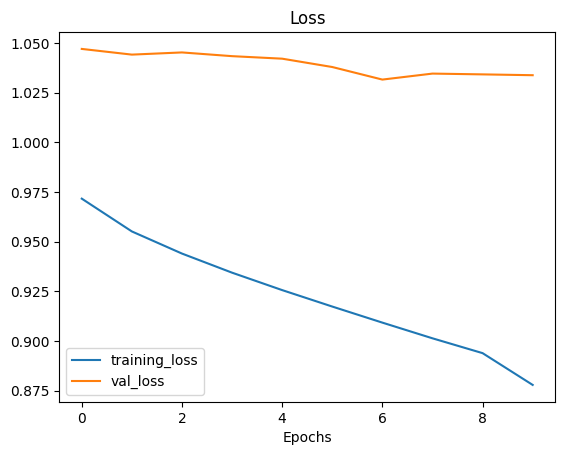

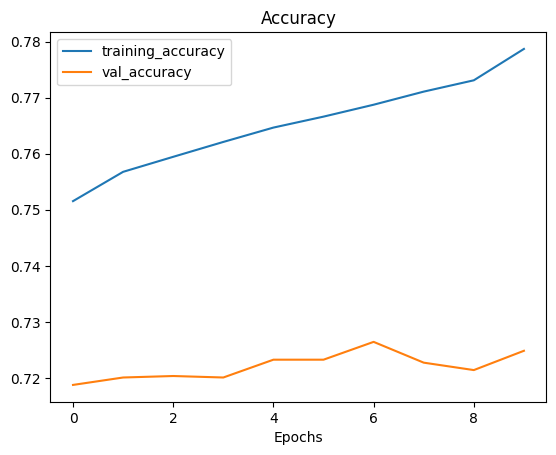

In [ ]:
from mmm import plot_loss_curves
plot_loss_curves(keras_model_history)

In [ ]:
loaded_model_evaluate = loaded_fine_tuned_gs_model.evaluate(test_data)
loaded_model_evaluate

790/790 [==============================] - 55s 70ms/step - loss: 1.0336 - accuracy: 0.7215


[1.0336086750030518, 0.7215445637702942]

In [ ]:
# save to google drive
from google.colab import drive
drive.mount('/content/drive')
loaded_fine_tuned_gs_model.save(f'/content/drive/MyDrive/food101acc{int(loaded_model_evaluate [1]* 100)}')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# get our model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
!mkdir downloaded_fine_tuned_gs_model
!unzip 07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model

--2024-05-09 17:32:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46790356 (45M) [application/zip]
Saving to: ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  44.62M  23.1MB/s    in 1.9s    

2024-05-09 17:33:01 (23.1 MB/s) - ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’ saved [46790356/46790356]

Archive:  07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variab

In [ ]:
# load fine tuned model
loaded_model = tf.keras.models.load_model("/content/downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [ ]:
loaded_model_eva = loaded_model.evaluate(test_data)
loaded_model_eva

790/790 [==============================] - 64s 79ms/step - loss: 0.9072 - accuracy: 0.8015


[0.9072170257568359, 0.8014653325080872]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
loaded_fine_tuned_gs_model.save(f'/content/drive/MyDrive/food101_acc{int(loaded_model_eva[1]* 100)}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
